In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# !pip install torchtext

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.utils.data import DataLoader
from numpy.random import random
import torch.nn.functional as F
from nltk.translate.gleu_score import sentence_gleu


In [5]:
VOCAB_PATH='/content/drive/MyDrive/CS4248NLP/vocab.txt'
ENCODING_PATH = '/content/drive/MyDrive/CS4248NLP/train_tf_vectorized_data.pt'
MODEL_PATH = '/content/drive/MyDrive/CS4248NLP/rnn_model/model_weights.pt'

# **Loading Vocab**

In [6]:
import json
with open('/content/drive/MyDrive/CS4248NLP/word_to_index.json', 'r') as f:
    word_to_index = json.load(f)

In [7]:
index_to_word = {}

for word, index in word_to_index.items():
  index_to_word[str(index)] = word

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))

Available device: cpu


## **Loading Preprocess data**

In [9]:
data = torch.load('/content/drive/MyDrive/CS4248NLP/train_tf_vectorized_data.pt')

original_tensor = data['original']
output_corrected_tensor = data['output_corrected']

print(original_tensor.shape)
print(output_corrected_tensor.shape)

torch.Size([18707, 35])
torch.Size([18707, 35])


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(original_tensor, output_corrected_tensor, test_size=0.1, shuffle=True, random_state=0)

In [11]:
# X_test[:5]

In [12]:
# Y_train[:5]

# **Model Defintion**

In [15]:
class Encoder(nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params
        self.embedding = nn.Embedding(self.params.vocab_size_encoder, self.params.embed_size)
        self.num_directions = 2 if self.params.rnn_encoder_bidirectional == True else 1
        rnn = None
        if self.params.rnn_cell.upper() == "RNN":
            rnn = nn.RNN
        elif self.params.rnn_cell.upper() == "GRU":
            rnn = nn.GRU
        elif self.params.rnn_cell.upper() == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RNN Cell. Currently supported: RNN, GRU, LSTM")
        self.rnn = rnn(self.params.embed_size,
                       self.params.rnn_hidden_size,
                       num_layers=self.params.rnn_num_layers,
                       bidirectional=self.params.rnn_encoder_bidirectional,
                       dropout=self.params.rnn_dropout,
                       batch_first=True)

        self._init_weights()


    def forward(self, X):
        batch_size, _ = X.shape
        self.hidden = self._init_hidden(batch_size)
        X = self.embedding(X)
        output, hidden = self.rnn(X, self.hidden)
        hidden = self._create_final_hidden(hidden, batch_size)
        return output, hidden

    def _create_final_hidden(self, hidden, batch_size):
        if self.num_directions == 1:
            return hidden

        if self.params.rnn_cell.upper() == "LSTM":
            h = self._concat_directions(hidden[0], batch_size)
            c = self._concat_directions(hidden[1], batch_size)
            hidden = (h, c)
            pass
        else:
            hidden = self._concat_directions(hidden, batch_size)

        return hidden

    def _concat_directions(self, s, batch_size):
        X = s.view(self.params.rnn_num_layers, self.num_directions, batch_size, self.params.rnn_hidden_size)
        X = X.permute(0, 2, 1, 3)
        return X.contiguous().view(self.params.rnn_num_layers, batch_size, -1)

    def _init_hidden(self, batch_size):
        if self.params.rnn_cell.upper() == "LSTM":
            return (torch.zeros(self.params.rnn_num_layers * self.num_directions, batch_size, self.params.rnn_hidden_size).to(self.params.device),
                    torch.zeros(self.params.rnn_num_layers * self.num_directions, batch_size, self.params.rnn_hidden_size).to(self.params.device))
        else:
            return torch.zeros(self.params.rnn_num_layers * self.num_directions, batch_size, self.params.rnn_hidden_size).to(self.params.device)


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                torch.nn.init.uniform_(m.weight, -0.001, 0.001)
            elif isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)


In [16]:
class DotAttention(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, encoder_hidden_states, decoder_hidden_state):
        # Shape of tensors
        # encoder_hidden_states: (B, S, H)
        # decoder_hidden_state:  (B, H)
        attention_weights = torch.bmm(encoder_hidden_states, decoder_hidden_state.unsqueeze(2))
        attention_weights = F.softmax(attention_weights.squeeze(2), dim=1)
        context = torch.bmm(encoder_hidden_states.transpose(1,2), attention_weights.unsqueeze(2)).squeeze(2)
        return torch.cat((context, decoder_hidden_state), dim=1), attention_weights

In [53]:
class Decoder(nn.Module):

    def __init__(self, params, criterion):
        super().__init__()
        self.params = params
        self.criterion = criterion
        self.embedding = nn.Embedding(self.params.vocab_size_decoder, self.params.embed_size)
        self.encoder_num_directions = 2 if self.params.rnn_encoder_bidirectional == True else 1
        self.hidden_dim = self.params.rnn_hidden_size * self.encoder_num_directions

        rnn = None
        if self.params.rnn_cell.upper() == "RNN":
            rnn = nn.RNN
        elif self.params.rnn_cell.upper() == "GRU":
            rnn = nn.GRU
        elif self.params.rnn_cell.upper() == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RNN Cell. Currently supported: RNN, GRU, LSTM")

        self.hidden_size = self.params.rnn_hidden_size * self.encoder_num_directions

        self.rnn = rnn(self.params.embed_size,
                       self.hidden_size,
                       num_layers=self.params.rnn_num_layers,
                       bidirectional=False,
                       dropout=self.params.rnn_dropout,
                       batch_first=True)

        if self.params.attention.upper() == "DOT":
            self.attention = DotAttention()
            self.first_linear_factor = 2
        else:
            self.first_linear_factor = 1

        linear_sizes = [params.rnn_hidden_size * self.encoder_num_directions * self.first_linear_factor] + params.linear_hidden_sizes

        self.linears = nn.ModuleList()
        for i in range(len(linear_sizes)-1):
            if params.linear_dropout > 0.0:
                self.linears.append(nn.Dropout(p=params.linear_dropout))
            self.linears.append(nn.Linear(linear_sizes[i], linear_sizes[i+1]))
            self.linears.append(nn.ReLU())

        self.out = nn.Linear(linear_sizes[-1], params.vocab_size_decoder)
        self._init_weights()


    def forward(self, inputs, hidden, encoder_hidden_states):
        batch_size, num_steps = inputs.shape
        token = torch.LongTensor([[self.params.special_token_sos]] * batch_size).to(self.params.device)
        use_teacher_forcing = random(1)[0] < self.params.teacher_forcing_prob
        loss = 0
        total_loss = 0.0
        total_non_pad_tokens = 0
        for i in range(num_steps):
            output, hidden, attention_weights = self._step(token, hidden, encoder_hidden_states)
            PAD_IDX = 0
            mask = inputs[:, i] != PAD_IDX
            step_loss = self.criterion(output, inputs[:, i])
            masked_loss = step_loss * mask.float()
            non_pad_tokens = mask.sum()
            total_loss += step_loss.sum()
            total_non_pad_tokens += non_pad_tokens
            if use_teacher_forcing:
                token = inputs[:, i].unsqueeze(dim=1)
            else:
                topv, topi = output.topk(1)
                token = topi.detach()

        # Normalize total loss by the number of non-pad tokens (to get average loss per token)
        if total_non_pad_tokens > 0:
            loss = total_loss / total_non_pad_tokens
        else:
            loss = torch.tensor(0.0).to(device)  # Avoid division by zero
        #print("total_loss:\t{} total_non_pad_tokens{} input.shape {}".format(total_loss, total_non_pad_tokens, inputs.shape))

        return loss



    def generate(self, hidden, encoder_hidden_states, max_len=100):

        decoded_sequence = []
        # Create SOS token tensor as first input for decoder
        token = torch.LongTensor([[self.params.special_token_sos]] * 1).to(self.params.device)

        decoder_attentions = torch.zeros(max_len, encoder_hidden_states.shape[1])

        # Loop over each item in the target sequences (must have the same length!!!)
        for i in range(max_len):
            output, hidden, attention_weights = self._step(token, hidden, encoder_hidden_states)

            # Update attention weights matrix with the latest values
            if self.params.attention.upper() == "DOT":
                decoder_attentions[i] = attention_weights

            # Get index of hightest value
            topv, topi = output.data.topk(1)
            if topi.item() == self.params.special_token_eos:
                break
            else:
                decoded_sequence.append(topi.item())
                token = topi.detach()

        return decoded_sequence, decoder_attentions[:i]



    def _step(self, token, decoder_hidden_state, encoder_hidden_states):
        # encoder_outputs.shape = (B x S x H)
        # Get embedding of current input word:
        X = self.embedding(token)
        # Push input word through rnn layer with current hidden state
        output, hidden = self.rnn(X, decoder_hidden_state)
        # output.shape = (B x S=1 x D)
        # hidden.shape = (L x B x H)

        if self.params.rnn_cell.upper() == "LSTM":
            last_hidden = hidden[0][-1]
        else:
            last_hidden = hidden[-1]
        # last_hidden.shape = (B x H)

        if self.params.attention.upper() == "DOT":
            output, attention_weights = self.attention(encoder_hidden_states, last_hidden)
        else:
            output, attention_weights = last_hidden, None

        for l in self.linears:
            output = l(output)
        output = self.out(output)
        return output, hidden, attention_weights




    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                torch.nn.init.uniform_(m.weight, -0.001, 0.001)
            elif isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)


class Dict2Class():

    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

In [19]:
class RnnAttentionSeq2Seq(nn.Module):

    def __init__(self, params, criterion):
        super().__init__()
        self.params = params
        self.criterion = criterion
        self.encoder = Encoder(params)
        self.decoder = Decoder(params, self.criterion)

    def forward(self, X, Y):
        encoder_outputs, encoder_hidden = self.encoder(X)
        loss = self.decoder(Y, encoder_hidden, encoder_outputs)
        return loss

    def train(self):
        self.encoder.train()
        self.decoder.train()

    def eval(self):
        self.encoder.eval()
        self.decoder.eval()


In [20]:
len(word_to_index)

22584

In [21]:
word_to_index['<PAD>']

21455

In [22]:
params = {
    "device": device,
    "vocab_size_encoder": len(word_to_index),
    "vocab_size_decoder": len(word_to_index),
    "embed_size": 300,
    "rnn_cell": "LSTM",
    "rnn_hidden_size": 512,
    "rnn_num_layers": 2,
    "rnn_dropout": 0.2,
    "rnn_encoder_bidirectional": False,
    "linear_hidden_sizes": [1024, 2048],
    "linear_dropout": 0.2,
    "attention": "DOT",
    "teacher_forcing_prob": 1,
    "special_token_unk": word_to_index['<UNK>'],
    "special_token_sos": word_to_index['<SOS>'],
    "special_token_eos": word_to_index['<EOS>'],
    "clip": 1.0
}

params = Dict2Class(params)

In [23]:
model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss(ignore_index=word_to_index['<PAD>'], reduction='none')).to(device)
encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(model.decoder.parameters(), lr=0.001)
print(model)

RnnAttentionSeq2Seq(
  (criterion): CrossEntropyLoss()
  (encoder): Encoder(
    (embedding): Embedding(22584, 300)
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (criterion): CrossEntropyLoss()
    (embedding): Embedding(22584, 300)
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
    (attention): DotAttention()
    (linears): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=1024, out_features=1024, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=1024, out_features=2048, bias=True)
      (5): ReLU()
    )
    (out): Linear(in_features=2048, out_features=22584, bias=True)
  )
)


In [24]:
print(np.count_nonzero(X_train[:3], axis=1))


[35 35 35]


In [25]:
logits = model(X_train[:2].to(device), Y_train[:2].to(device))

# **Train Model**

In [26]:
def train_batch(model, encoder_optimizer, decoder_optimizer, X, Y):
    batch_size, num_steps = X.shape

    loss = model(X, Y)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.encoder.parameters(), model.encoder.params.clip)
    torch.nn.utils.clip_grad_norm_(model.decoder.parameters(), model.decoder.params.clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item()


In [28]:
def train(model, loader, encoder_optimizer, decoder_optimizer, num_epochs, verbose=True):
    model.train()
    print("Total Training Time (total number of epochs: {})".format(num_epochs))
    for epoch in range(1, num_epochs+1):
        epoch_loss = 0.0
        with tqdm(total=len(loader)) as progress_bar:
            for X_batch, Y_batch in loader:
                batch_size, seq_len = X_batch.shape[0], X_batch.shape[1]
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                batch_loss = train_batch(model, encoder_optimizer, decoder_optimizer, X_batch, Y_batch)
                epoch_loss += batch_loss
                progress_bar.update(1)

        if verbose is True:
            print("Loss:\t{:.3f} (epoch {})".format(epoch_loss, epoch))

In [27]:
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=64, shuffle=False)

In [29]:
X_train.shape

torch.Size([16836, 35])

In [30]:
train_loader.batch_size

64

In [31]:
num_epochs = 25
train_loader = DataLoader(list(zip(X_train[:10000], Y_train[:10000])), batch_size=1024, shuffle=True)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=64, shuffle=False)

In [ ]:
train(model, train_loader, encoder_optimizer, decoder_optimizer, num_epochs, verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


Loss:	41.315 (epoch 1)


100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


Loss:	33.456 (epoch 2)


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Loss:	32.517 (epoch 3)


100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


Loss:	31.746 (epoch 4)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	30.905 (epoch 5)


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Loss:	30.181 (epoch 6)


100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


Loss:	29.536 (epoch 7)


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Loss:	28.905 (epoch 8)


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Loss:	28.270 (epoch 9)


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Loss:	27.685 (epoch 10)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	27.181 (epoch 11)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	26.707 (epoch 12)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	26.252 (epoch 13)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	25.842 (epoch 14)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	25.357 (epoch 15)


100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


Loss:	24.922 (epoch 16)


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Loss:	24.435 (epoch 17)


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Loss:	23.967 (epoch 18)


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Loss:	23.535 (epoch 19)


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Loss:	23.086 (epoch 20)


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Loss:	22.597 (epoch 21)


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Loss:	22.158 (epoch 22)


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Loss:	21.684 (epoch 23)


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


Loss:	21.317 (epoch 24)


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]

Loss:	20.916 (epoch 25)


In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

In [32]:
# Load the model from file
model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss(ignore_index=word_to_index['<PAD>'], reduction='none')).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
print(model.encoder.embedding.weight.shape)
print(model.encoder.embedding.padding_idx)

torch.Size([22584, 300])
None


## **Evaluate model**
# *Calculating GLEU (Google BLEU) Score *


In [34]:
def translate(model, inputs, max_len=100):
    model.eval()
    encoder_outputs, encoder_hidden = model.encoder(inputs)
    decoded_indices, attention_weights = model.decoder.generate(encoder_hidden, encoder_outputs, max_len=max_len)
    return decoded_indices, attention_weights

In [ ]:
model.eval()
with torch.no_grad():
  glue_score_arr = []
  for idx, (inputs, targets) in enumerate(test_loader):
      inputs = inputs[0:1].to(device)
      src_labels = [index_to_word[str(wrd_idx)] for wrd_idx in inputs[0].cpu().numpy().tolist()]
      targets_labels = [index_to_word[str(wrd_idx)] for wrd_idx in targets[0].cpu().numpy().tolist()]
      decoded_indices, attention_weights = translate(model, inputs)
      tgt_labels = [index_to_word[str(wrd_idx)] for wrd_idx in decoded_indices]
      tgt_labels_str = ' '.join(tgt_labels).replace('<EOS>', '').replace('<PAD>', '')
      src_labels_str = ' '.join(src_labels).replace('<EOS>', '').replace('<PAD>', '')
      targets_labels_str = ' '.join(targets_labels).replace('<EOS>', '').replace('<PAD>', '')
      print("Incorrect:", src_labels_str)
      print("Target:" , tgt_labels_str)
      print("Expected: ", targets_labels_str)
      glue_score_arr.append(sentence_gleu([tgt_labels_str], targets_labels_str))

Incorrect: You could work in a public office for example .                         
Target: I am writing to be a car .
Expected:  You could work in a public office , for example .                        
Incorrect: - There in a recycling facility near our village and 80 percent of the rubbish is being recycled .                
Target: The first thing I was a little servant and I was a little bit .
Expected:  - There is a recycling facility near our village and 80 percent of the rubbish is being recycled .                
Incorrect: I the town you can do everything fun .                          
Target: I am writing to be a great way .
Expected:  In a town you can do everything fun .                          
Incorrect: If the sheets are bad , those sheets are then destroyed through burning .                     
Target: The actress Masquerade , and he was a little BECAUSE IT 'S TOO EXPENSIVE .
Expected:  If the sheets are bad , those sheets are then destroyed by burning .            

In [ ]:
glue_score_arr

[0.10839160839160839,
 0.21555555555555556,
 0.15040650406504066,
 0.18285714285714286,
 0.23963133640552994,
 0.0918918918918919,
 0.27530364372469635,
 0.2555066079295154,
 0.34801762114537443,
 0.2546816479400749,
 0.17193675889328064,
 0.19069767441860466,
 0.22850678733031674,
 0.28087649402390436,
 0.1872791519434629,
 0.22696245733788395,
 0.16602316602316602,
 0.06060606060606061,
 0.17549668874172186,
 0.2742857142857143,
 0.15088757396449703,
 0.27598566308243727,
 0.36363636363636365,
 0.24434389140271492,
 0.12146892655367232,
 0.12849162011173185,
 0.11788617886178862,
 0.1850828729281768,
 0.25365853658536586,
 0.26305220883534136]

#Evaluation of model to get F0.5 score
**Submitting to competition**

In [35]:
model.eval()
file_path = '/content/drive/MyDrive/CS4248NLP/test_dataset/competition_test.txt'
sentences = []
lines = []
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()
    lines = content.split('\n')

for line in lines:
    clean_line = line.strip()
    sentences.append(clean_line)

print("total_Sentences", len(sentences))

total_Sentences 4477


In [ ]:
# Set the model to evaluation mode
output_file_path = '/content/drive/MyDrive/CS4248NLP/rnn_model/competition_test_output1.txt'

with torch.no_grad():
  with open(output_file_path, 'w', encoding='utf-8') as output_file_path:
    for id, input in enumerate(sentences):
      print("input", id)
      inputs_lst = input.split(" ")
      if (len(inputs_lst) >= 1):
        #print(inputs_lst)
        inputs_idx = [word_to_index[wrd] for wrd in inputs_lst if wrd in word_to_index]
        #print(inputs_idx)
        if (len(inputs_idx) > 0):
          original_tensor = torch.tensor(inputs_idx).view(1,-1)
          #print(original_tensor.shape)
          decoded_indices, attention_weights = translate(model, original_tensor)

          # Decode target sequence of indices to sequences of word/tokens
          tgt_labels = [index_to_word[str(wrd_idx)] for wrd_idx in decoded_indices]

          tgt_labels_str = ' '.join(tgt_labels).replace('<EOS>', '').replace('<PAD>', '')
          src_labels_str = ' '.join(src_labels).replace('<EOS>', '').replace('<PAD>', '')

          # Print input and translation
          #print("Incorrect:", src_labels_str)
          #print("Target:" , tgt_labels_str)
          output_file_path.write(tgt_labels_str + '\n')
        else:
          output_file_path.write(input + '\n')
      else:
        output_file_path.write(input + '\n')


input 0
input 1
input 2
input 3
input 4
input 5
input 6
input 7
input 8
input 9
input 10
input 11
input 12
input 13
input 14
input 15
input 16
input 17
input 18
input 19
input 20
input 21
input 22
input 23
input 24
input 25
input 26
input 27
input 28
input 29
input 30
input 31
input 32
input 33
input 34
input 35
input 36
input 37
input 38
input 39
input 40
input 41
input 42
input 43
input 44
input 45
input 46
input 47
input 48
input 49
input 50
input 51
input 52
input 53
input 54
input 55
input 56
input 57
input 58
input 59
input 60
input 61
input 62
input 63
input 64
input 65
input 66
input 67
input 68
input 69
input 70
input 71
input 72
input 73
input 74
input 75
input 76
input 77
input 78
input 79
input 80
input 81
input 82
input 83
input 84
input 85
input 86
input 87
input 88
input 89
input 90
input 91
input 92
input 93
input 94
input 95
input 96
input 97
input 98
input 99
input 100
input 101
input 102
input 103
input 104
input 105
input 106
input 107
input 108
input 109
input 110


# **Evaluation Model: Visualising Attention**

In [51]:
model.eval()
with torch.no_grad():
  glue_score_arr = []
  for idx, (inputs, targets) in enumerate(test_loader):
      if (idx == 10):
        inputs = inputs[0:1].to(device)
        src_labels = [index_to_word[str(wrd_idx)] for wrd_idx in inputs[0].cpu().numpy().tolist()]
        targets_labels = [index_to_word[str(wrd_idx)] for wrd_idx in targets[0].cpu().numpy().tolist()]
        decoded_indices, attention_weights = translate(model, inputs)
        tgt_labels = [index_to_word[str(wrd_idx)] for wrd_idx in decoded_indices]
        tgt_labels_str = ' '.join(tgt_labels).replace('<EOS>', '').replace('<PAD>', '')
        src_labels_str = ' '.join(src_labels).replace('<EOS>', '').replace('<PAD>', '')
        targets_labels_str = ' '.join(targets_labels).replace('<EOS>', '').replace('<PAD>', '')
        print("Incorrect:", src_labels_str)
        print("Target:" , tgt_labels_str)
        print("Expected: ", targets_labels_str)
        glue_score_arr.append(sentence_gleu([tgt_labels_str], targets_labels_str))
        break

Incorrect: This powerful vehicle is counted vital for another reason : being an indispensable factor in many aspects .                 
Target: I am writing to have a lot of people and I am interested .
Expected:  This powerful vehicle is considered vital for another reason : being an indispensable factor in many respects .                 


['This', 'powerful', 'vehicle', 'is', 'counted', 'vital', 'for', 'another', 'reason', ':', 'being', 'an', 'indispensable', 'factor', 'in', 'many', 'aspects', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['I', 'am', 'writing', 'to', 'have', 'a', 'lot', 'of', 'people', 'and', 'I', 'am', 'interested', '.']


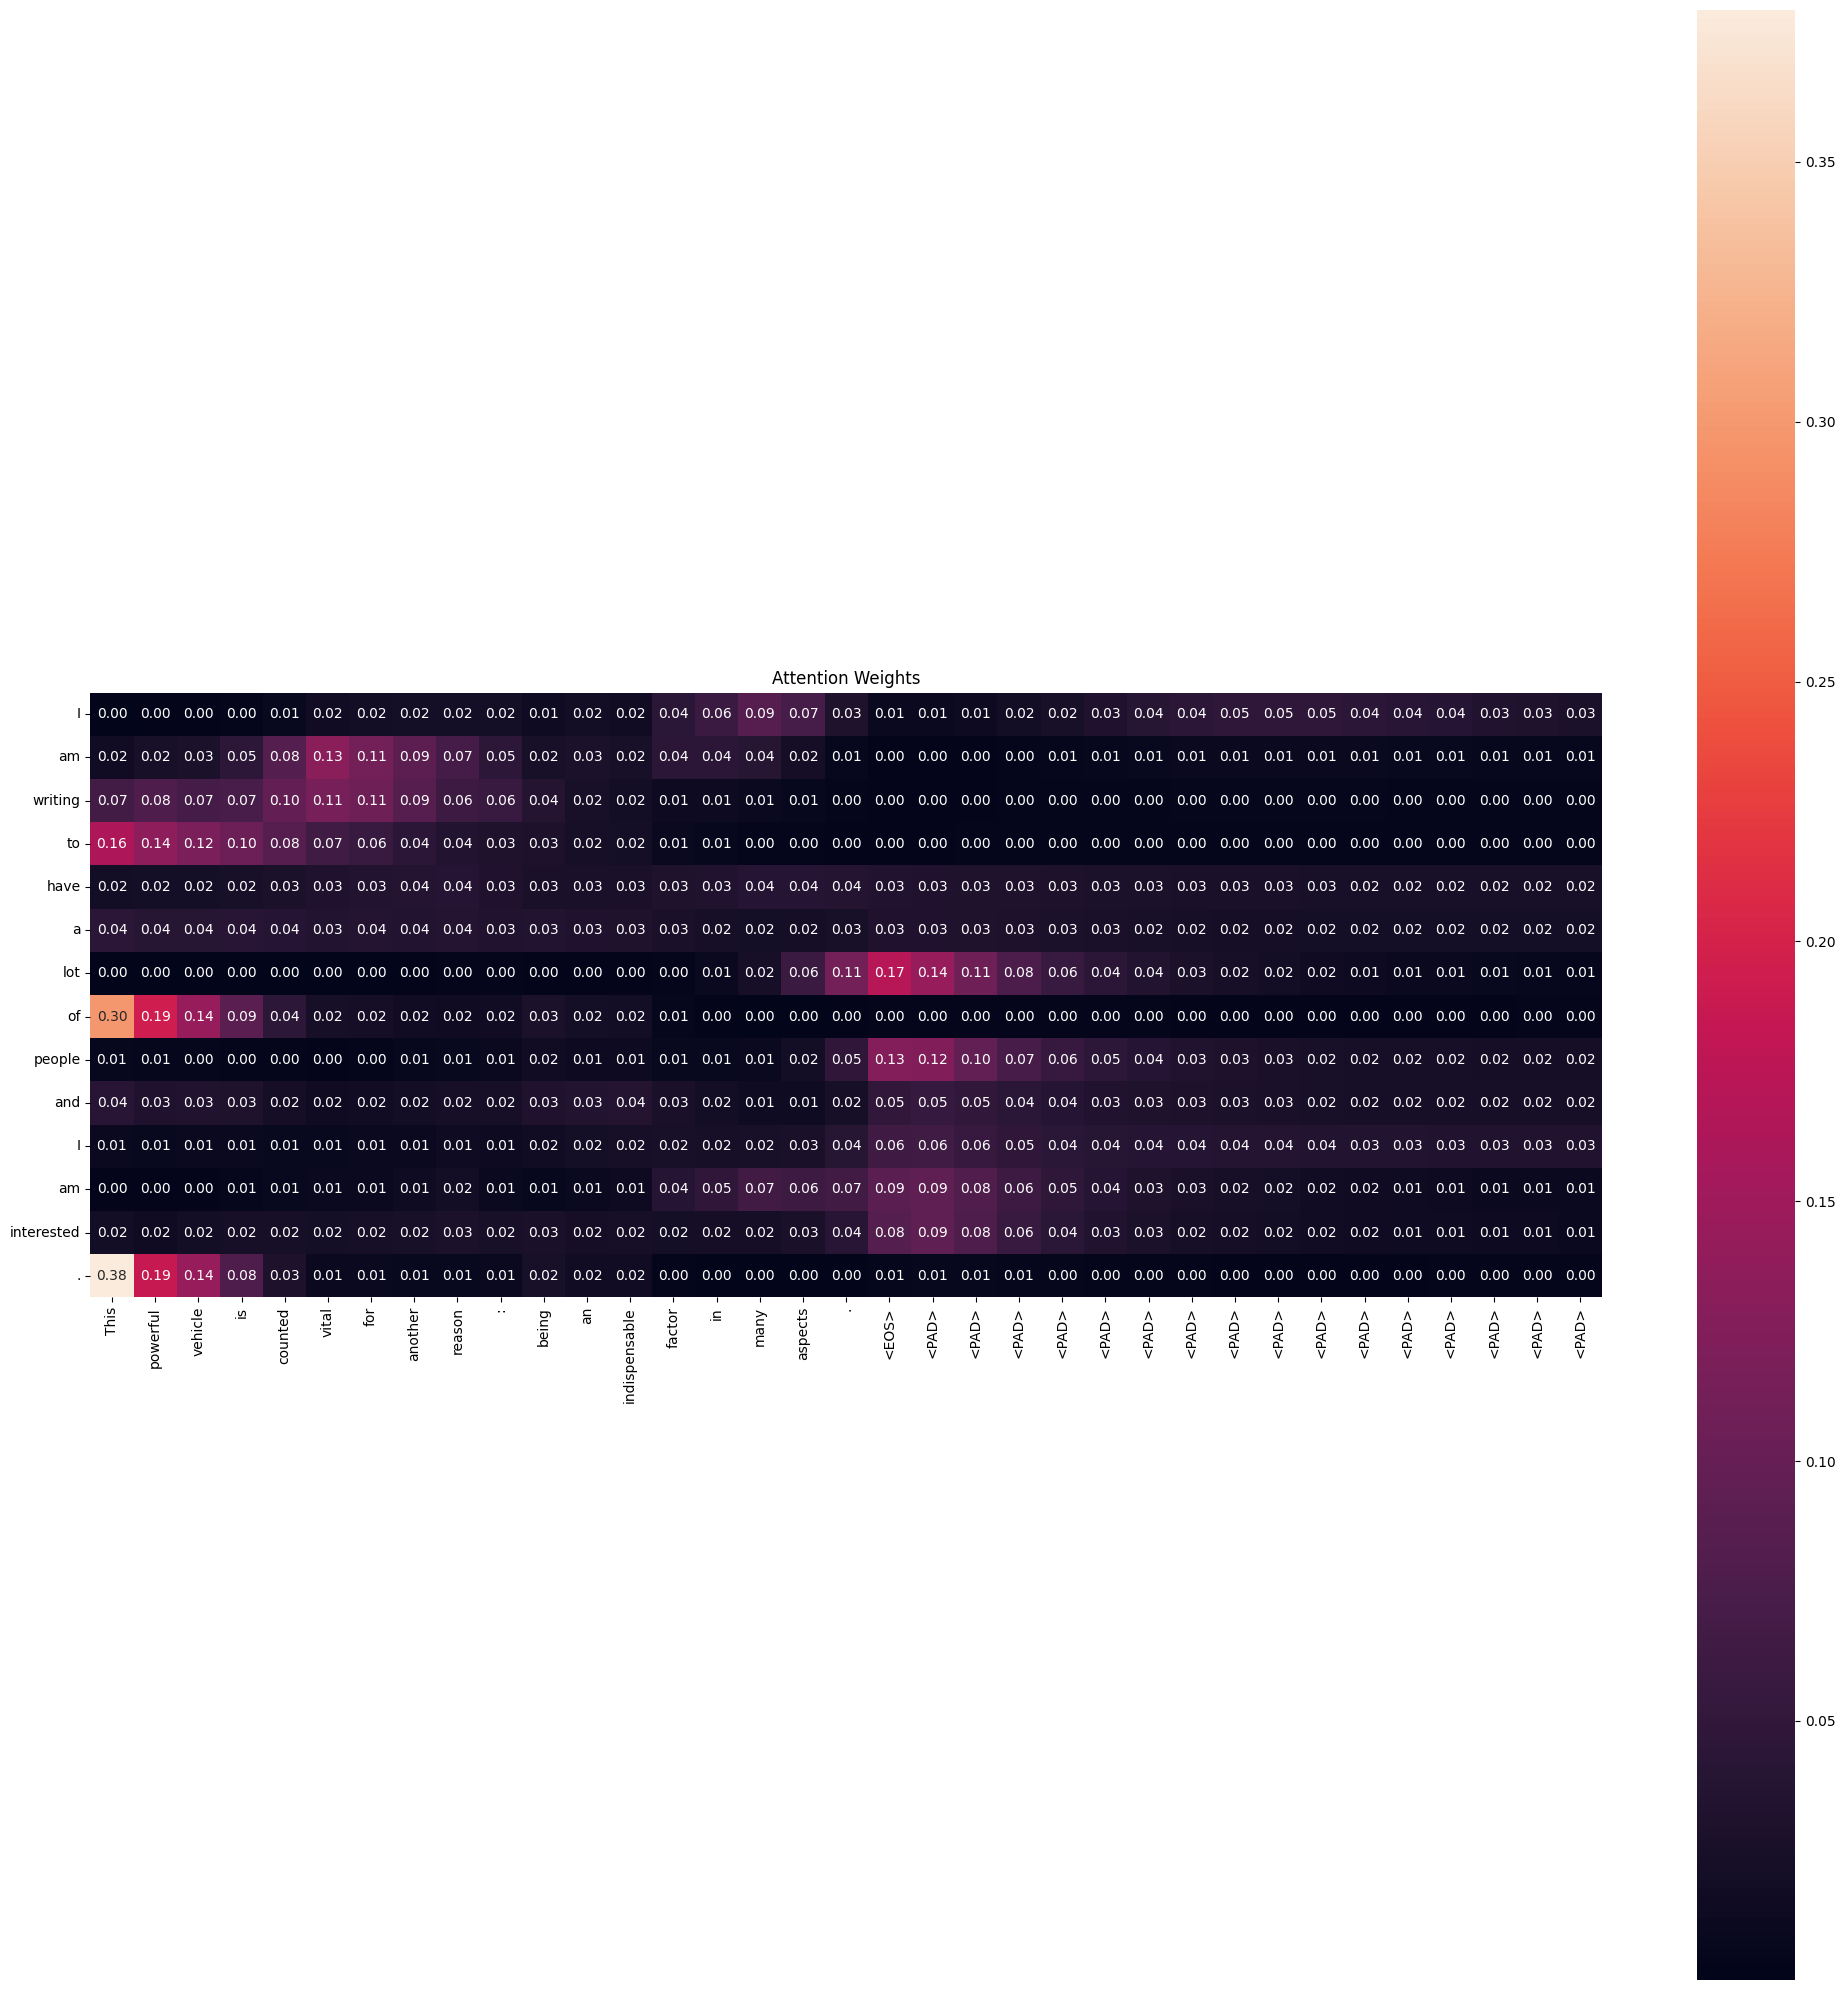

In [52]:
weights = attention_weights.detach().cpu().numpy()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
print(src_labels)
print(tgt_labels)
plt.figure(figsize=(20,20))
hm = sns.heatmap(weights,
                  cbar=True,
                  annot=True,
                  square=True,
                  fmt='.2f',
                  annot_kws={'size': 10},
                  yticklabels=tgt_labels,
                  xticklabels=src_labels)
plt.title('Attention Weights')
plt.tight_layout()
plt.show()
